In [1]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Import packages


In [2]:
from plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
import os
import math
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import xgboost           as xgb

from scipy                     import stats
from scipy.stats               import norm
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model      import SGDRegressor
from sklearn                   import svm
from xgboost                   import XGBRegressor,plot_importance
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import f1_score,log_loss
from sklearn.preprocessing     import LabelEncoder
from scipy.stats.stats         import pearsonr
from scipy.special             import boxcox1p

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Packages imported!')
%matplotlib inline

Packages imported!


## Load data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.read_csv('data.csv')
print('rows in dataset:', data.shape[0], ', columns:', data.shape[1])
print('rows in train dataset:', train.shape[0], ', columns:', train.shape[1])
print('rows in test dataset:', test.shape[0], ', columns:', test.shape[1])

rows in dataset: 2917 , columns: 79
rows in train dataset: 1460 , columns: 81
rows in test dataset: 1459 , columns: 80


In [6]:
# outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [7]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

## Target Variable

Unlike classification, in regression we are predicting a continuous number. Hence, the prediction could be any number along the real number line.

Therefore, it is always useful to check the distribution of the target variable, and indeed all numeric variables, when building a regression model. Machine Learning algorithms work well with features that are normally distributed, a distribution that is symmetric and has a characteristic bell shape. If features are not normally distributed, you can transform them using clever statistical methods.

First, let's check the target variable.

/home/yasser/anaconda3/envs/AMMI/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


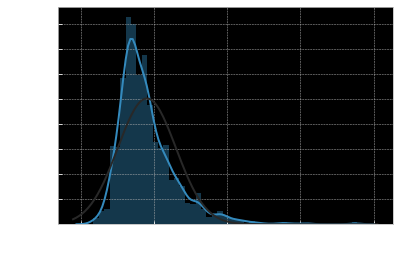

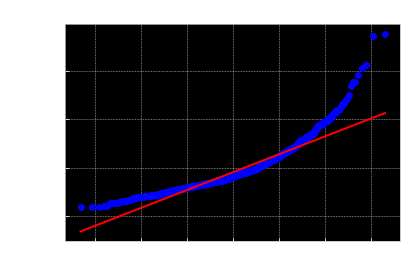

In [8]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

The distribution of the target variable is positively skewed, meaning that the mode is always less than the mean and median.

In order to transform this variable into a distribution that looks closer to the black line shown above, we can use the numpy function log1p which applies log(1+x) to all elements within the feature.

In [9]:
train["SalePrice"] = np.log(train["SalePrice"])

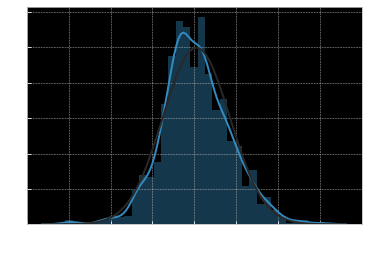

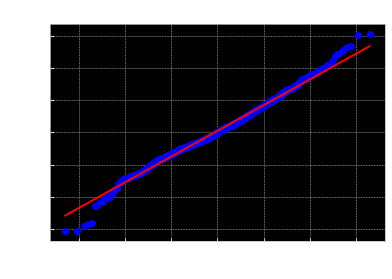

In [10]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

We can see from the skewness and the plot that it follows much more closely to the normal distribution now. This will help the algorithms work most reliably because we are now predicting a distribution that is well-known, i.e. the normal distribution. If the distribution of your data approximates that of a theoretical distribution, we can perform calculations on the data that are based on assumptions of that well-known distribution.

In [11]:
# Also save the target value, as we will remove this
y_train = train.SalePrice.values
label = train.SalePrice

## Feature Engineering

In [12]:
# transforming year and month into categorical features
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [13]:
# gonna try putting overall condition as categorical
data['OverallCond'] = data['OverallCond'].astype(str)
data['OverallQual'] = data['OverallQual'].astype(str)

In [14]:
# MSSubClass should be categorical as well
data['MSSubClass'] = data['MSSubClass'].astype(str)

In [15]:
# Overall SF? we have TotalBsmtSF, 1stFlrSF and 2ndFlrSF 
# might be worth putting them together into a "overall SF"category?
data['OverallSF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']

In [16]:
data['Remod_Diff'] =  data['YearRemodAdd'] -  data['YearBuilt']

going to try combining categorical data with it's quality:
- BsmtQual * BsmtCond

- OverallQual * Neighborhood

- Condition1 * Condition2

- BldgType * OverallQual

- ExterQual * ExterCond

- KitchenQual * OverallQual

- GarageType * GarageQual

- GarageType * GarageCond

- MoSold * YrSold

- SaleType * SaleCondition

- SaleType * OverallCond

In [17]:
# data['BsmnQual_BsmtCond']         = data['BsmtQual']    + data['BsmtCond']
# data['OverallQual_Neighborhood']  = data['OverallQual'] + data['Neighborhood']
# data['Condition1_Condition2']     = data['Condition1']  + data['Condition2']
# data['BldgType_OverallQual']      = data['BldgType']    + data['OverallQual']
# data['ExterQual_ExterCond']       = data['ExterQual']   + data['ExterCond']
# data['KitchenQual_OverallQual']   = data['KitchenQual'] + data['OverallQual']
# data['GarageType_GarageQual']     = data['GarageType']  + data['GarageQual']
# data['GarageType_GarageCond']     = data['GarageType']  + data['GarageCond']
# data['MoSold_YrSold']             = data['MoSold']      + data['YrSold']
# data['SaleType_SaleCondition']    = data['SaleType']    + data['SaleCondition']
# data['SaleType_OverallCond']      = data['SaleType']    + data['OverallCond']

with all but garageType_garageQual and MoSold_YrSold turned off, I got .12000, which insinuates there's something here that increases my accuracy.

## Figuring out what to do with Nominal & Ordinal Categories

According to the Data Documentation this is the breakdown on the Nominal and Ordinal Categories:

- Nomial categories

"MSSubClass", MSZoning, "Street", "Alley", LandContour, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1, Exterior2, MasVnrType, MasVnrArea, Foundation, Heating, "CentralAir", GarageType, MiscFeature, SaleType, SaleCondition

- Ordinal Categories

LotShape, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, Electrical, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence

In [18]:
cat_feats = data.dtypes[data.dtypes == "object"].index
cat_feats

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

We learned to use One-Hot Encoding for linear models and label encoder for trees, but since i'm trying to use a mix of different models I'm going to use:

- Label Encoding for the ordinal categories -categories where the order of the data might matter, 

- One-Hot Encoding for the nominal categories

#### Label Encoding for the ordinal categories


In [19]:
category = ('LotShape', 'LandSlope', 'OverallQual','OverallCond', 'ExterQual', 'ExterCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
            'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
            'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence')

for c in category:
    lbl = LabelEncoder()
    lbl.fit(list(data[c].values))
    data[c] = lbl.transform(list(data[c].values))

# Treating skewed features

As touched on earlier, skewed numeric variables are not desirable when using Machine Learning algorithms. The reason why we want to do this is move the models focus away from any extreme values, to create a generalised solution. We can tame these extreme values by transforming skewed features.

Right, so originally we thought that we'd try and fix the Skew of our independant variables, since linear regressions (which are my focus) are highly succeptible to outliers. Unfortunately, this formula only improved the positively skewed variables.  the negatively skewed variables only got worse. I tried running this but instead of increasing our score it hurt it. so we ended up taking this out of our final version.  Given more time, I'd probably try log transforming individual categories then spot-check them.

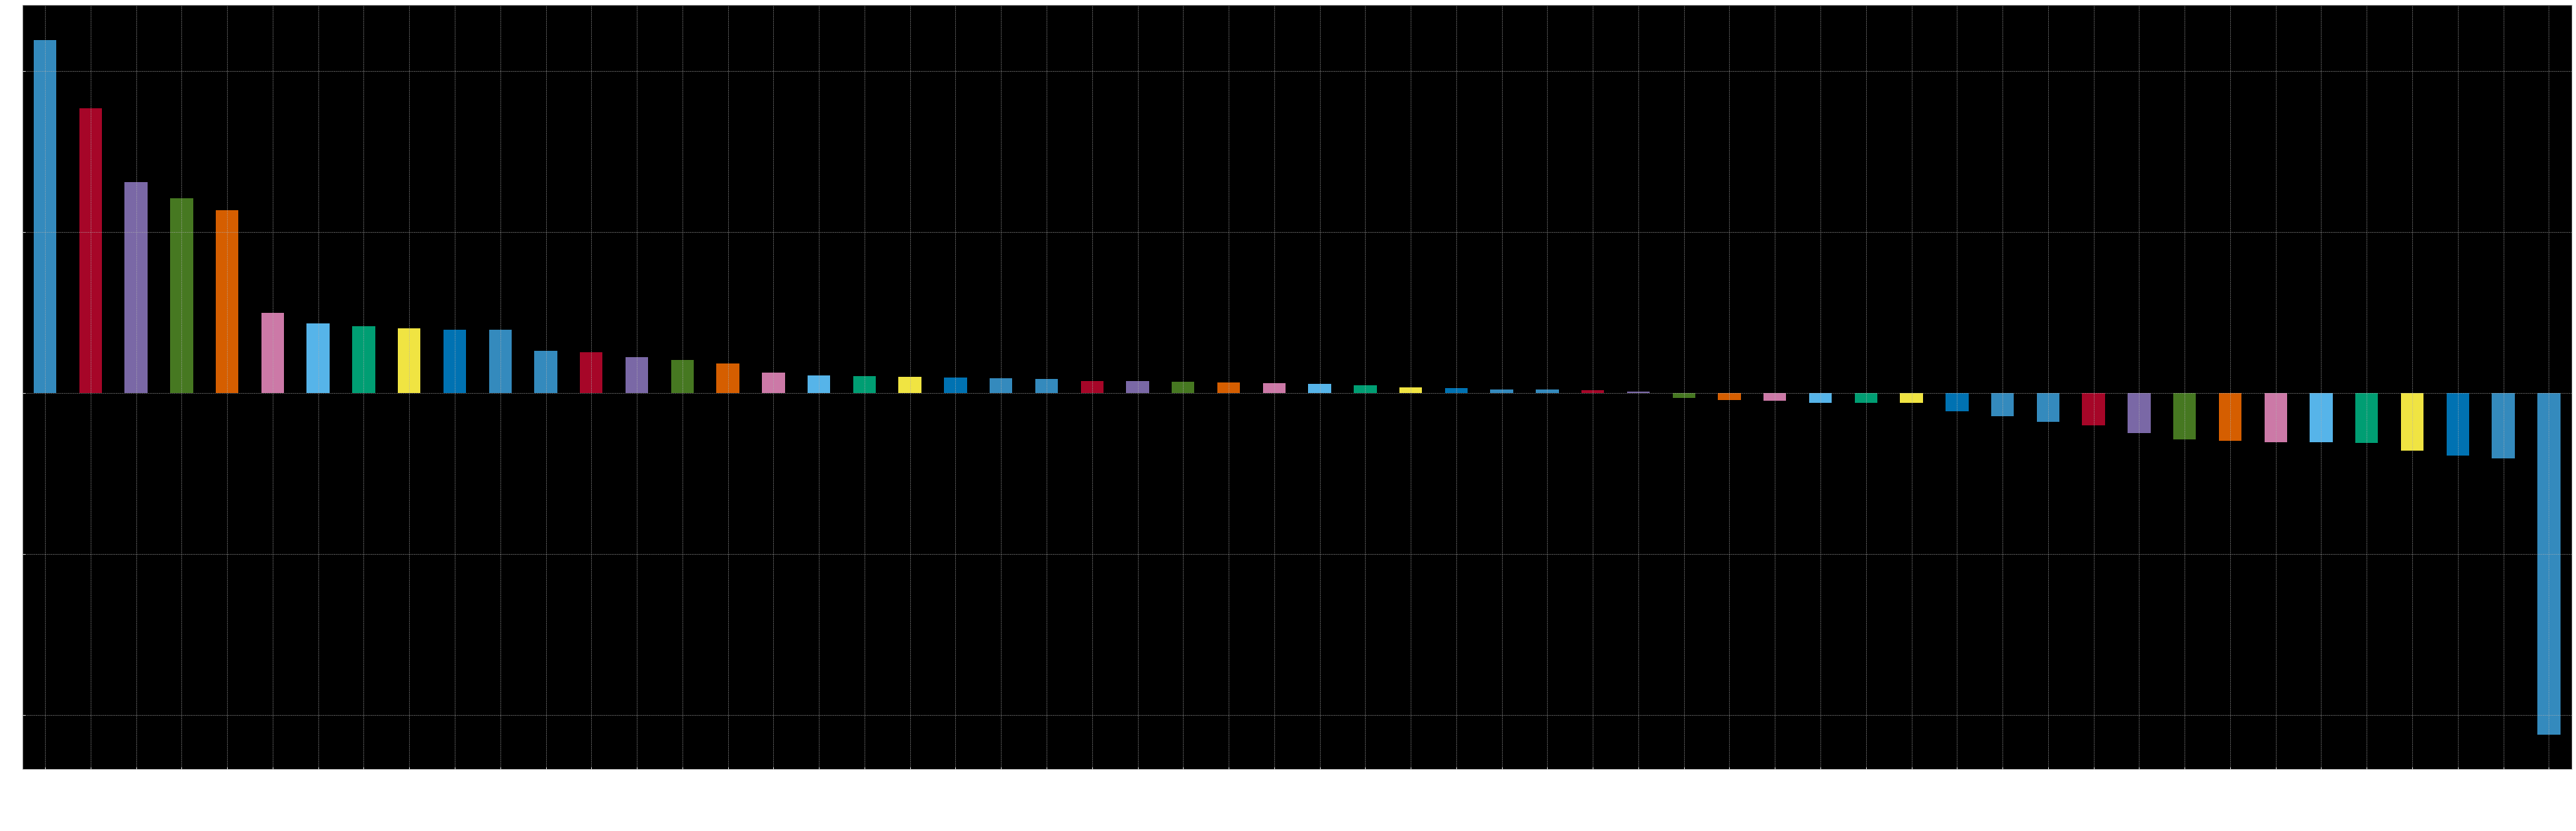

In [20]:
numerical = data.dtypes[data.dtypes != "object"].index
skewed = data[numerical].apply(lambda x: x.skew()).sort_values(ascending=False)
plt.subplots(figsize =(65, 20))
skewed.plot(kind='bar');

Clearly, we have a variety of positive and negative skewing features. Now I will transform the features with skew > 0.5 to follow more closely the normal distribution.

In [21]:
skewdf = pd.DataFrame({'Skew': skewed})
skewdf = skewdf[(skewdf)>0.5]
skewed = skewdf.index
lam = 0.15
for feat in skewed:
    data[feat] = boxcox1p(data[feat], lam)

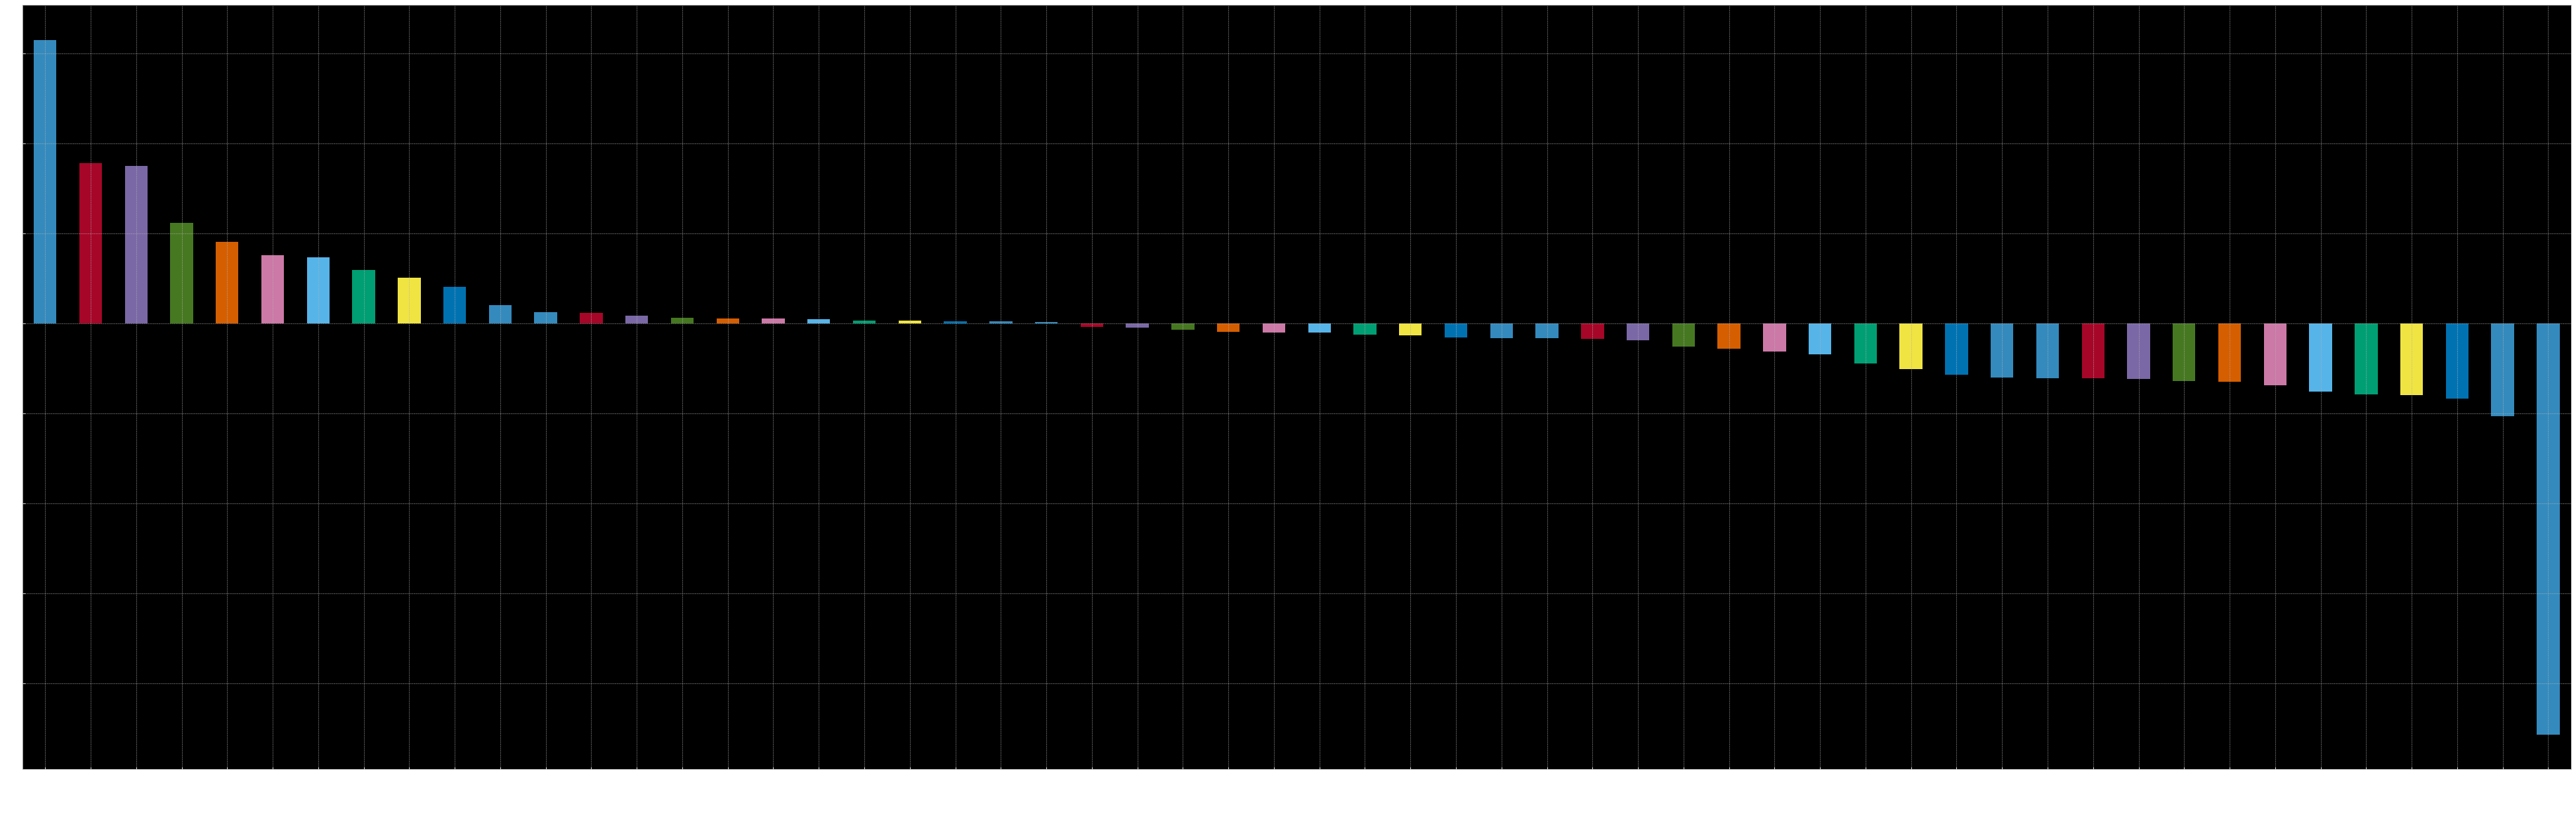

In [22]:
newskewed = data[numerical].apply(lambda x: x.skew()).sort_values(ascending=False)
plt.subplots(figsize =(65, 20))
newskewed.plot(kind='bar');

#### One-Hot Encoding for the nominal categories

get_dummies() is just one hot encoding the nominal categories

In [23]:
Nomial_categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

for c in Nomial_categories:
    data = pd.get_dummies(data, columns = [c], prefix=c)

#### Re-separating the data into test and train

In [24]:
# First, re-create the training and test datasets
train = data[:ntrain]
test = data[ntrain:]

print(train.shape)
print(test.shape)

(1458, 252)
(1459, 252)


In [25]:
train.to_csv('train_cleaning.csv',index=False)
test.to_csv('test_cleaning.csv',index=False)

In [26]:
prediction = pd.DataFrame(y_train, columns=['SalePrice']).to_csv('y_train.csv',index=False)
# y_train.to_csv('y_train.csv',header=True,index=False)

## Feature choosing

### Lasso

In [27]:
sgd_l1 = SGDRegressor(max_iter=30, penalty="l1", random_state=1,alpha=1e-2)
sgd_l1.fit(train, y_train)

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=30,
       n_iter=None, n_iter_no_change=5, penalty='l1', power_t=0.25,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [28]:
sgd_l1.coef_.min(), sgd_l1.coef_.max()

(-17489212982.452793, 21835699694.49461)

In [29]:
good_feats = np.abs(np.array(sgd_l1.coef_)) > 1e+10 

print("Features reduced from %10d to %10d" % (train.shape[1], int(good_feats.sum())))

Features reduced from        252 to         39


In [30]:
train_l1_select = train.loc[:, good_feats]
test_l1_select  = test.loc[:, good_feats]

In [31]:
train_l1_select.to_csv('train_lasso.csv',index=False)
test_l1_select.to_csv('test_lasso.csv',index=False)

### XGBRegressor

In [32]:
model = XGBRegressor(max_depth=5,n_estimators=1000,learning_rate=1e-2)
model.fit(train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

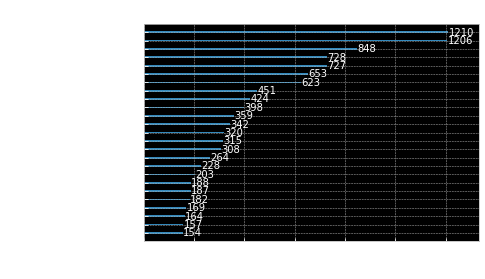

In [33]:
plot_importance(model,max_num_features=25)

In [34]:
good_feats_xgb = np.abs(np.array(model.feature_importances_)) > 1e-2
print("Features reduced from %10d to %10d" % (train.shape[1], int(good_feats_xgb.sum())))

Features reduced from        252 to         23


In [35]:
train_xgb_select = train.loc[:, good_feats_xgb]
test_xgb_select = test.loc[:, good_feats_xgb]

In [36]:
train_xgb_select.to_csv('train_xgb.csv',index=False)
test_xgb_select.to_csv('test_xgb.csv',index=False)

### XGB

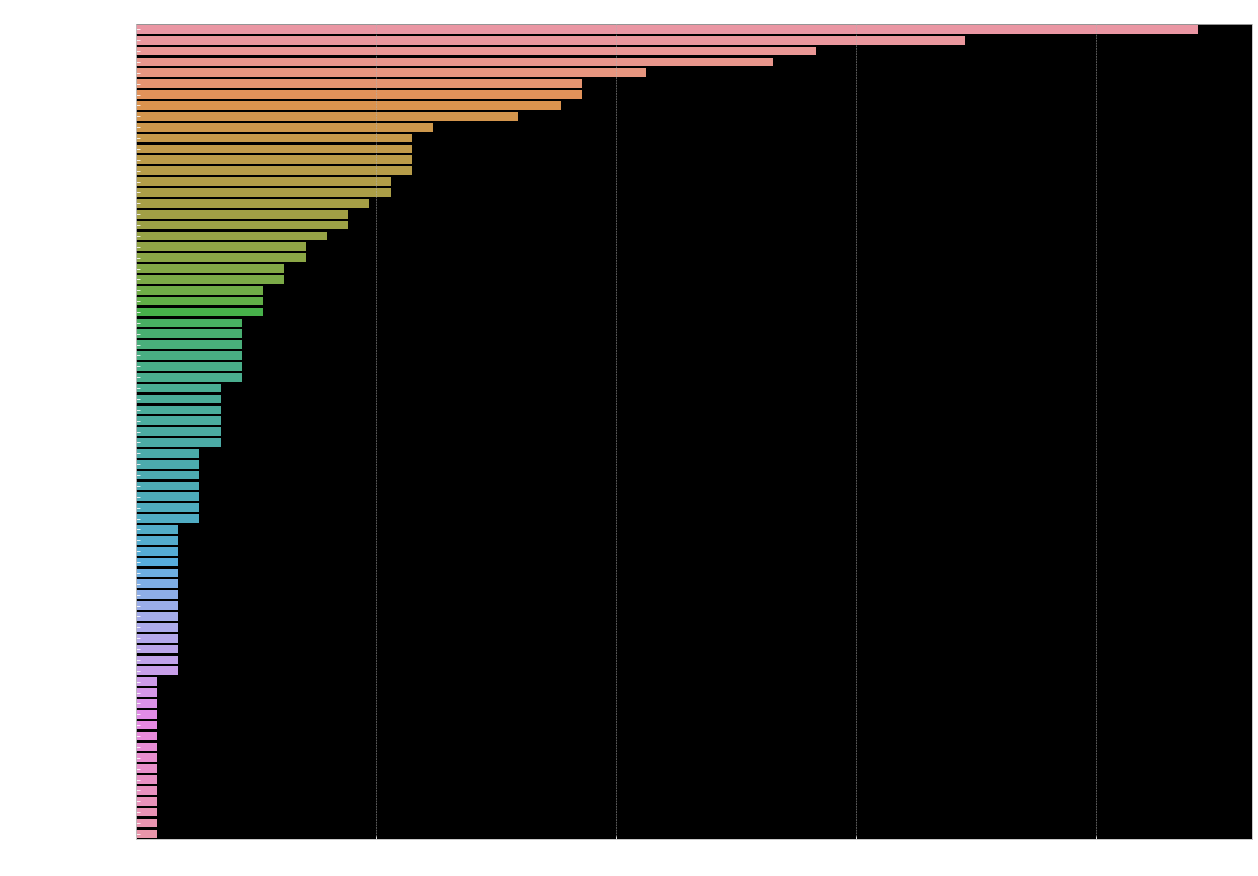

In [37]:
model = xgb.XGBRegressor()
model.fit(train, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [38]:
xgb_train = train.copy()
xgb_test = test.copy()

In [39]:
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1458, 46) 
X_test:  (1459, 46)


In [40]:
xgb_train = pd.DataFrame(xgb_train)
xgb_test  = pd.DataFrame(xgb_test)

In [41]:
xgb_train.to_csv('xgb_train_cleaning.csv',index=False)
xgb_test.to_csv('xgb_test_cleaning.csv',index=False)

## PCA

In [42]:
from sklearn.decomposition import PCA

pca = PCA(0.95)

In [43]:
pca_train = pca.fit_transform(train)
pca_test  = pca.fit_transform(test)

In [44]:
pca_train.shape, pca_test.shape

((1458, 23), (1459, 23))

In [45]:
pca_train = pd.DataFrame(pca_train)
pca_test  = pd.DataFrame(pca_test)

In [46]:
# plt.scatter(pca_data[:,0],pca_data[:,1])

In [47]:
pca_train.to_csv('pca_train_cleaning.csv',index=False)
pca_test.to_csv('pca_test_cleaning.csv',index=False)